# Tutorial 3: Analysis of STARmap MPVC data

The following tutorials demonstrates how to use PAST to obtain latent embeddings and decipher spatial domains on STARmap Mouse Primary Visual Cortex (MPVC) dataset([Wang, et al., 2018](https://www.science.org/doi/10.1126/science.aat5691)).

There are three parts in this tutorial:

+ **Integrating self-prior data to analyze MPVC dataset.** This part will show you how to utilize target preprocessed gene expression matrix as self-prior matrix to obtain latent embeddings and spatial clusters on STARmap MPVC dataset.

+ **Integrating 10x Visium data to analyze MPVC dataset.** This part will show you how to take advantage of a 10x Visium Mouse Brain Coronal dataset to construct external-prior matrix for latent feature extraction and spatial clustering on STARmap MPVC dataset.

+ **Integrating scRNA-seq data to analyze MPVC dataset.** This part will show you how to use a scRNA-seq Mouse Primary Visual Cortex dataset([Tasic, et al., 2016](https://www.nature.com/articles/nn.4216)) to construct external-prior matrix for latent feature extraction and spatial clustering on STARmap MPVC dataset.

In [1]:
import past
import os
import scanpy as sc
import warnings
import torch
import numpy as np
import pandas as pd

In [2]:
warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=80, figsize=(3,3), facecolor="white")
os.environ["R_HOME"] = "/home/lizhen/anaconda3/envs/scTECH-R/lib/R"
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

The data used in this tutorial is available at [TsinghuaCloudDisk](https://cloud.tsinghua.edu.cn/d/9ab272a99ffb4104a37d/).

In [4]:
## STARmap MPVC DATASET
os.chdir("/home/lizhen/code/PAST/Data")
STARmap_MPVC = sc.read_h5ad(filename="STARmap_MPVC.h5ad")
STARmap_MPVC

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'cellname', 'CellID', 'celltype', 'celltype_class', 'layer_label'
    var: 'genename'
    obsm: 'spatial'

## Integrating self-prior data to analyze MPVC dataset

We set a random seed for all random process for reproducibility.

In [5]:
past.setup_seed(666)
sdata = STARmap_MPVC.copy()

Next, we filter out genes expressed in less than three spots and follow [the Scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html) for spatial transcriptomics to normalize and logarithmize the count matrix. Since the gene number of STARmap MPVC dataset is less than 3000, there is no need to proceed with the step of gene selection.

In [6]:
sdata = past.preprocess(sdata, min_cells=3)

Initialization of PAST model.

In [7]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

We train PAST model without specifying external reference data, and PAST will automatically utilize the preprocessed target STARmap MPVC anndata as self-prior marix.

In [8]:
PAST_model.model_train(sdata, epochs=50, lr=1e-3, device=device)

This dataset is smaller than batchsize so that ripple walk sampler is not used!
Epoch:10 Time:4.56s Loss: 10.746432
Epoch:20 Time:0.36s Loss: 5.447495
Epoch:30 Time:0.49s Loss: 4.406228
Epoch:40 Time:0.38s Loss: 3.716350
Epoch:50 Time:0.34s Loss: 3.143820
Epoch:60 Time:0.38s Loss: 2.658507
Epoch:70 Time:0.39s Loss: 2.167424
Epoch:80 Time:0.42s Loss: 1.723445
Epoch:90 Time:0.34s Loss: 1.274822
Epoch:100 Time:0.29s Loss: 0.907798
Epoch:110 Time:0.31s Loss: 0.654606
Epoch:120 Time:0.38s Loss: 0.490456
Epoch:130 Time:0.31s Loss: 0.381233
Epoch:140 Time:0.32s Loss: 0.317329
Epoch:150 Time:0.31s Loss: 0.277530
Epoch:160 Time:0.28s Loss: 0.251747
Epoch:170 Time:0.28s Loss: 0.229579
Epoch:180 Time:0.37s Loss: 0.210894
Model Converge


We can obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [9]:
sdata = PAST_model.output(sdata)

The clustering result of mclust and louvain with default parameters is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [10]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["layer_label"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [11]:
print("Cross-validation score:", end="\t\t")
acc, kappa, mf1, wf1 = past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["layer_label"])
print("Acc: %.3f, K: %.3f, mF1: %.3f, wF1: %.3f"%(acc.mean(), kappa.mean(), mf1.mean(), wf1.mean()))

print("Mclust metrics:", end="\t\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "layer_label", "mclust")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

print("Dlouvain metrics:", end="\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "layer_label", "Dlouvain")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

Cross-validation score:		Acc: 0.785, K: 0.742, mF1: 0.754, wF1: 0.778
Mclust metrics:			ARI: 0.564, AMI: 0.643, NMI: 0.646, FMI:0.644, Comp: 0.670, Homo: 0.623
Dlouvain metrics:		ARI: 0.502, AMI: 0.607, NMI: 0.610, FMI:0.580, Comp: 0.597, Homo: 0.624


Visualization of latent embeddings colored by ground truth and PAST-derived clusters.

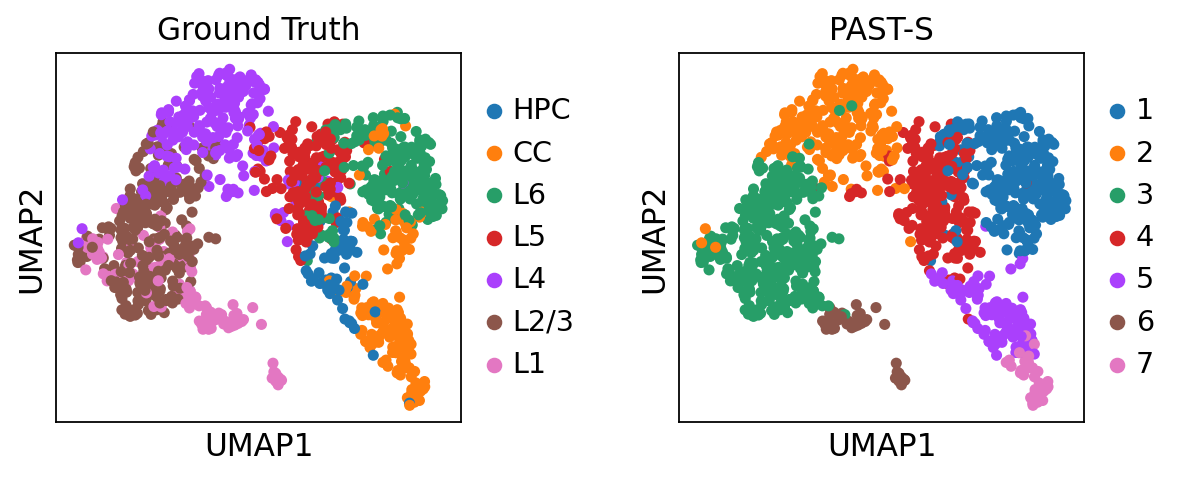

In [12]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["layer_label", "mclust"], title=["Ground Truth", "PAST-S"], wspace=0.4)

Visualization of spatial domains colored by ground truth and PAST-derived clusters.

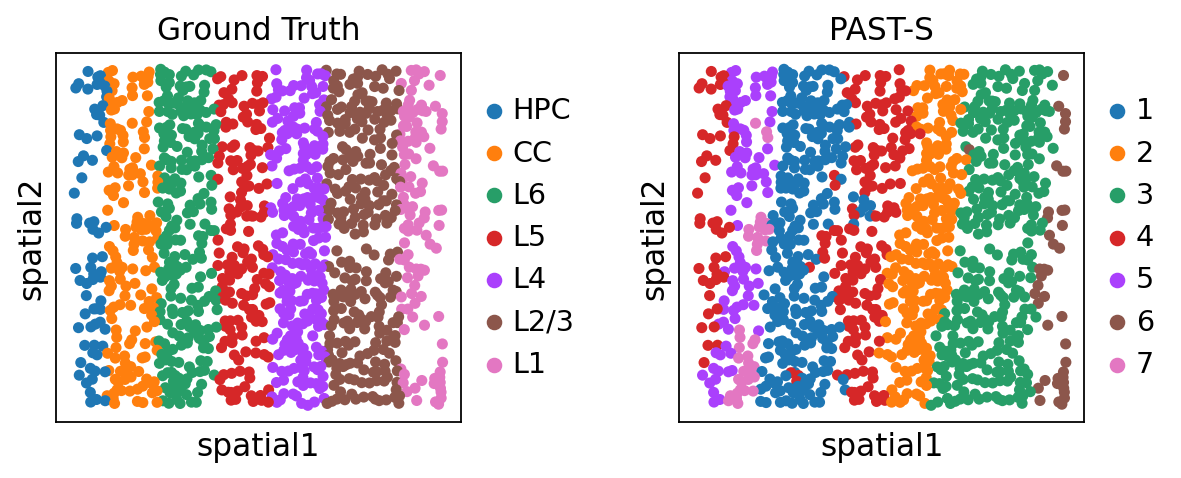

In [13]:
sc.pl.embedding(sdata, color=["layer_label", "mclust"], basis="spatial", title=["Ground Truth", "PAST-S"], wspace=0.4)

## Integrating 10x Visium data to analyze MPVC dataset

We set a random seed for all random process for reproducibility.

In [14]:
past.setup_seed(666)
sdata = STARmap_MPVC.copy()

Same as above, we filter out genes expressed in less than three spots, normalize and logarithmize the count matrix.

In [15]:
sdata = past.preprocess(sdata, min_cells=3)

Here we utilize a 10x Visium Mouse Brain Coronal dataset as reference data for further external-prior matrix construction, denoted as `rdata`. The spatial domain annotation of the refernece data was conducted by squidpy([Palla, et al., 2022](https://www.nature.com/articles/s41592-021-01358-2)) and the gene expression profile combined with annotation could be downloaded from [squidpy package](https://squidpy.readthedocs.io/en/latest/auto_tutorials/tutorial_visium_hne.html).

You can also uncomment and execute the following command to download the 10X Visium MBC dataset in AnnData format. 

In [16]:
# !wget https://health.tsinghua.edu.cn/software/PAST/data/10x_MBC.h5ad

We first align the gene set of `rdata` to that of `sdata` through `past.integration()` function, process `rdata`, and then construct pseudo-bulk external-prior matrix using `past.get_bulk()` function based on spatial domain labels of reference data.

In [17]:
rdata = sc.read_h5ad(filename="/home/lizhen/code/PAST/Data/10x_MBC.h5ad")
rdata = past.integration(rdata, sdata)
rdata = past.preprocess(rdata, min_cells=None, target_sum=None, n_tops=None)
rdata = past.get_bulk(rdata, key="cluster")
rdata

add 51 zero features to reference; Current total 1020 genes
bulk_data's shape: (15, 1020)


AnnData object with n_obs × n_vars = 15 × 1020

Initialization of PAST model.

In [18]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

Then we train PAST with pseudo-bulk external-prior matrix constructed in the last step.

In [19]:
PAST_model.model_train(sdata, rdata=rdata, epochs=50, lr=1e-3, device=device)

This dataset is smaller than batchsize so that ripple walk sampler is not used!
Epoch:10 Time:0.44s Loss: 10.927820
Epoch:20 Time:0.41s Loss: 5.538719
Epoch:30 Time:0.37s Loss: 4.528119
Epoch:40 Time:0.39s Loss: 3.818742
Epoch:50 Time:0.28s Loss: 3.269794
Epoch:60 Time:0.42s Loss: 2.775824
Epoch:70 Time:0.24s Loss: 2.328353
Epoch:80 Time:0.34s Loss: 1.889098
Epoch:90 Time:0.30s Loss: 1.446759
Epoch:100 Time:0.38s Loss: 1.073192
Epoch:110 Time:0.34s Loss: 0.786154
Epoch:120 Time:0.36s Loss: 0.575390
Epoch:130 Time:0.41s Loss: 0.431946
Epoch:140 Time:0.42s Loss: 0.349050
Epoch:150 Time:0.34s Loss: 0.296875
Epoch:160 Time:0.35s Loss: 0.265067
Epoch:170 Time:0.29s Loss: 0.239507
Epoch:180 Time:0.36s Loss: 0.221549
Model Converge


We can obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [20]:
sdata = PAST_model.output(sdata)

The clustering result of mclust and louvain with default parameters is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [21]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["layer_label"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [22]:
print("Cross-validation score:", end="\t\t")
acc, kappa, mf1, wf1 = past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["layer_label"])
print("Acc: %.3f, K: %.3f, mF1: %.3f, wF1: %.3f"%(acc.mean(), kappa.mean(), mf1.mean(), wf1.mean()))

print("Mclust metrics:", end="\t\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "layer_label", "mclust")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

print("Dlouvain metrics:", end="\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "layer_label", "Dlouvain")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

Cross-validation score:		Acc: 0.754, K: 0.705, mF1: 0.742, wF1: 0.751
Mclust metrics:			ARI: 0.553, AMI: 0.617, NMI: 0.620, FMI:0.634, Comp: 0.644, Homo: 0.598
Dlouvain metrics:		ARI: 0.384, AMI: 0.493, NMI: 0.498, FMI:0.484, Comp: 0.493, Homo: 0.503


Visualization of latent embeddings colored by ground truth and PAST-derived clusters.

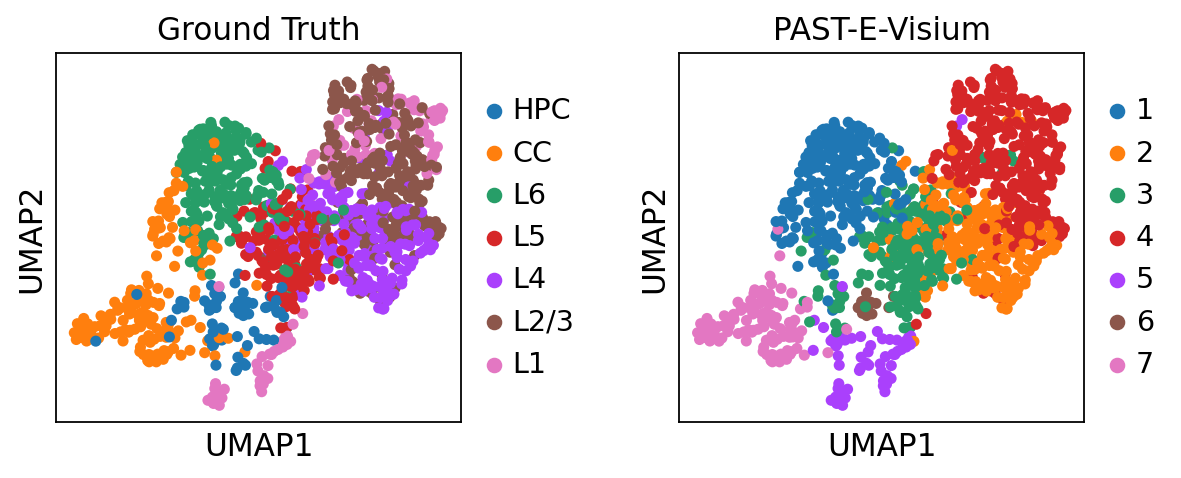

In [23]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["layer_label", "mclust"], title=["Ground Truth", "PAST-E-Visium"], wspace=0.4)

Visualization of spatial domains colored by ground truth and PAST-derived clusters.

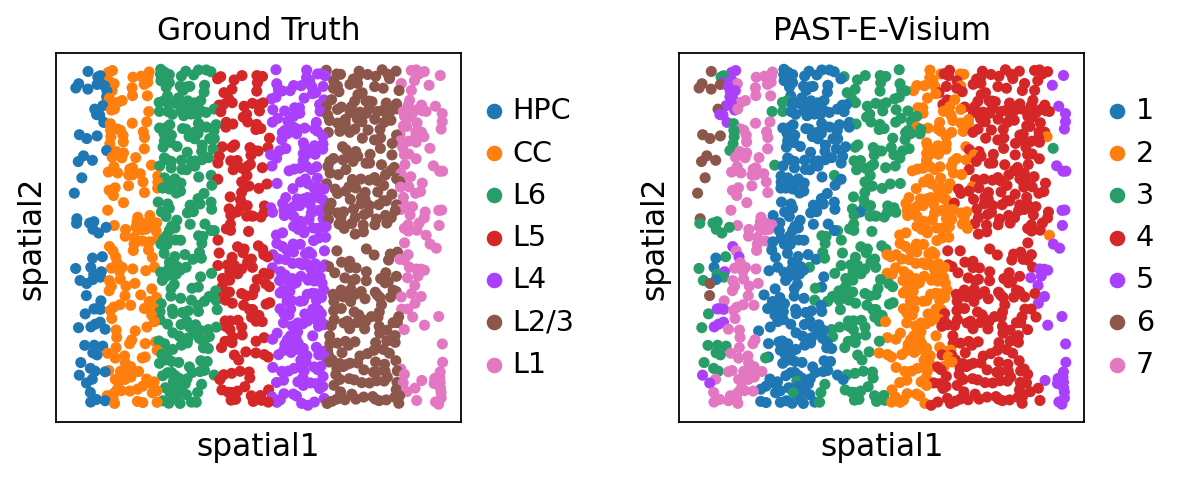

In [24]:
sc.pl.embedding(sdata, color=["layer_label", "mclust"], basis="spatial", title=["Ground Truth", "PAST-E-Visium"], wspace=0.4)

## Integrating scRNA-seq data to analyze MPVC dataset

We set a random seed for all random process for reproducibility.

In [25]:
past.setup_seed(666)
sdata = STARmap_MPVC.copy()

Here we utilize a scRNA-seq Mouse Primary Visual Cortex dataset([Tasic, et al., 2016](https://www.nature.com/articles/nn.4216)) as reference data for further external-prior matrix construction. The spatial domains annotation of the refernece data is stored in `rdata.obs["subclass"]`. 

You can uncomment and execute the following command to download the scRNA-seq dataset in AnnData format.

In [26]:
# !wget https://health.tsinghua.edu.cn/software/PAST/data/scRNAseq_MPVC.h5ad

Same as above, we filter out genes expressed in less than three spots, normalize and logarithmize the count matrix.

In [27]:
sdata = past.preprocess(sdata, min_cells=3)

We first align the gene set of `rdata` to that of `sdata` through `past.integration()` function, process `rdata`, and then construct pseudo-bulk external-prior matrix using `past.get_bulk()` function based on spatial domain labels of reference data.

In [28]:
rdata = sc.read_h5ad(filename="/home/lizhen/code/PAST/Data/scRNAseq_MPVC.h5ad")
rdata = past.integration(rdata, sdata)
rdata = past.preprocess(rdata, min_cells=None, target_sum=None, n_tops=None)
rdata = past.get_bulk(rdata, key="subclass")
rdata

add 26 zero features to reference; Current total 1020 genes
bulk_data's shape: (23, 1020)


AnnData object with n_obs × n_vars = 23 × 1020

Initialization of PAST model.

In [29]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

Then we train PAST with external-prior matrix.

In [30]:
PAST_model.model_train(sdata, rdata=rdata, epochs=50, lr=1e-3, device=device)

This dataset is smaller than batchsize so that ripple walk sampler is not used!
Epoch:10 Time:0.42s Loss: 10.408704
Epoch:20 Time:0.46s Loss: 5.622233
Epoch:30 Time:0.44s Loss: 4.609864
Epoch:40 Time:0.39s Loss: 3.892449
Epoch:50 Time:0.40s Loss: 3.286209
Epoch:60 Time:0.38s Loss: 2.759880
Epoch:70 Time:0.35s Loss: 2.250768
Epoch:80 Time:0.30s Loss: 1.756955
Epoch:90 Time:0.36s Loss: 1.300540
Epoch:100 Time:0.37s Loss: 0.913573
Epoch:110 Time:0.31s Loss: 0.635197
Epoch:120 Time:0.31s Loss: 0.464089
Epoch:130 Time:0.32s Loss: 0.351952
Epoch:140 Time:0.34s Loss: 0.291283
Epoch:150 Time:0.39s Loss: 0.250736
Epoch:160 Time:0.45s Loss: 0.225507
Epoch:170 Time:0.44s Loss: 0.207427
Epoch:180 Time:0.39s Loss: 0.194824
Model Converge


We can obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [31]:
sdata = PAST_model.output(sdata)

The clustering result of mclust and louvain with default parameters is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [32]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["layer_label"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [33]:
print("Cross-validation score:", end="\t\t")
acc, kappa, mf1, wf1 = past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["layer_label"])
print("Acc: %.3f, K: %.3f, mF1: %.3f, wF1: %.3f"%(acc.mean(), kappa.mean(), mf1.mean(), wf1.mean()))

print("Mclust metrics:", end="\t\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "layer_label", "mclust")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

print("Dlouvain metrics:", end="\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "layer_label", "Dlouvain")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

Cross-validation score:		Acc: 0.731, K: 0.676, mF1: 0.665, wF1: 0.720
Mclust metrics:			ARI: 0.533, AMI: 0.571, NMI: 0.575, FMI:0.610, Comp: 0.579, Homo: 0.570
Dlouvain metrics:		ARI: 0.445, AMI: 0.507, NMI: 0.512, FMI:0.531, Comp: 0.497, Homo: 0.528


Visualization of latent embeddings colored by ground truth and PAST-derived clusters.

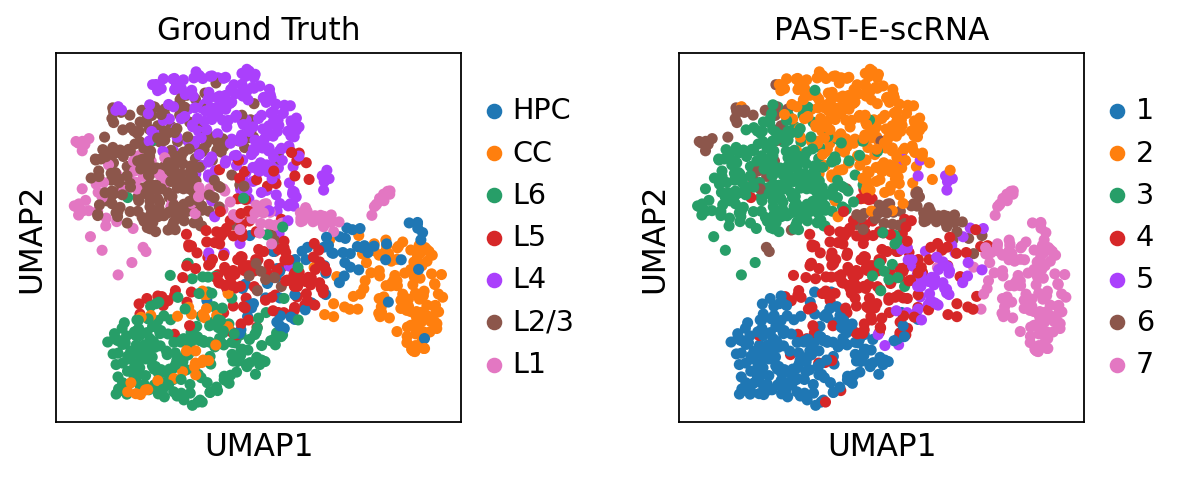

In [34]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["layer_label", "mclust"], title=["Ground Truth", "PAST-E-scRNA"], wspace=0.4)

Visualization of spatial domains colored by ground truth and PAST-derived clusters.

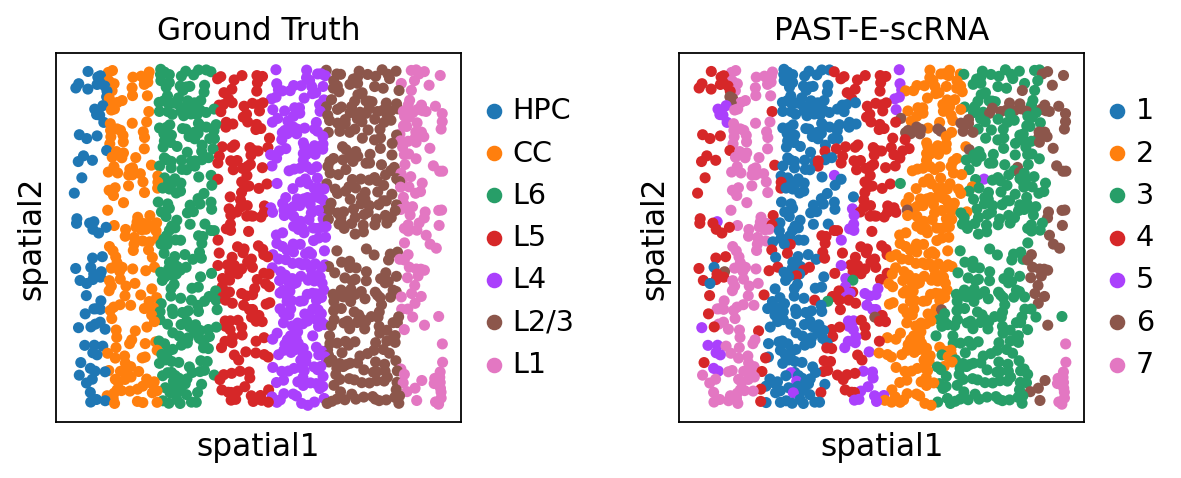

In [35]:
sc.pl.embedding(sdata, color=["layer_label", "mclust"], basis="spatial", title=["Ground Truth", "PAST-E-scRNA"], wspace=0.4)